In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2, os, math, time
from datetime import timedelta
from sklearn.utils import shuffle

In [ ]:
tf.__version__

In [ ]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

### Configuration

In [2]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir="../gen_script/data"
img_dir_same = img_dir + "/1"
img_dir_diff = img_dir + "/0"

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 256             # Number of neurons in fully-connected layer.

### Load Data

In [3]:
def change_label_dimensions(labels):
    label_temp = np.zeros((len(labels), 2))
    
    for idx in range(0, len(labels)):
        if labels[idx] == 1:
            label_temp[idx][1] = 1
        else:
            label_temp[idx][0] = 1
    
    return label_temp

def load_data(img_dir, label):
        list_of_imgs = []
        list_of_labels = []
        for img in os.listdir(img_dir):
                img = os.path.join(img_dir, img)
#                 print(img)
                if not img.endswith(".png"):
                        continue

                list_of_imgs.append(img)
                list_of_labels.append(label)
        data_labels = np.asarray(list_of_labels, dtype=np.int32)
        data_imgs = np.array(list_of_imgs)
#         data_labels = np.array(list_of_labels)
        return data_imgs, data_labels
    
def get_batch_images(data, label):
        list_of_imgs = []
        list_of_labels = []
        for img, lbl in zip(data, label):
#             print(img, lbl)
            a = cv2.imread(img)
            if a is None:
                    print ("Unable to read image{}".format(img))
                    continue
            
            flattened_a = a.flatten()
#             flattened_a = tf.cast(flattened_a, tf.float32)
                
#             print(type(flattened_a.shape)) 
#             print(type(np.asarray(flattened_a, dtype=np.float32)))
            
            list_of_imgs.append(np.asarray(flattened_a, dtype=np.float32))
            list_of_labels.append(lbl)

        data_labels = np.asarray(list_of_labels, dtype=np.int32)
        data_imgs = np.array(list_of_imgs)
        
#         print(data_imgs)
#         print(data_labels)
        
        return data_imgs, data_labels

train_imgs_same, train_labels_same = load_data(img_dir_same, 0)
train_imgs_diff, train_labels_diff = load_data(img_dir_diff, 1)

# train_imgs = np.append(train_imgs_same, train_imgs_diff)
train_imgs = np.concatenate([train_imgs_same, train_imgs_diff])
train_lbls = np.append(train_labels_same, train_labels_diff)
print(len(train_lbls))
print(len(train_imgs), train_imgs.shape, len(train_lbls))
print(len(train_imgs_same), train_imgs_same.shape, len(train_labels_same))
print(len(train_imgs_diff), train_imgs_diff.shape, len(train_labels_diff))

# print(train_imgs, train_lbls)
train_data, train_labels = shuffle(train_imgs, train_lbls, random_state=0)

train_labels = change_label_dimensions(train_labels)
# print(train_data, train_labels)

1000000
1000000 (1000000,) 1000000
501297 (501297,) 501297
498703 (498703,) 498703


### Next Batch Own Implementation

In [4]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

### Data Dimensions

In [5]:
# We know that images are 60 pixels in each dimension.
# img_size = 8 * 4

# Images are stored in one-dimensional arrays of this length.
img_size_flat = 8 * 4

# Number of colour channels for the images: 3 channel for RGB.
num_channels = 3

# Tuple with height and width of images used to reshape arrays.
img_shape = (8, 4, num_channels)


# Number of classes, one class for same or different image
num_classes = 2

### Image Plot Functions

In [18]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(cv2.imread(images[i]).flatten().reshape((8,4, 3)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
def generate_size_graph(fig_no, training_size, accuracy, loss, patch_only,patch_conv, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.plot(training_size, patch_only)
    plt.plot(training_size, patch_conv)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Training Size vs Accuracy')
    plt.grid(True)
    plt.legend(['SD Original Accuracy','SR Accuracy', 'SD Patch Accuracy', 'SD Patch Conv'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['train','val'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg')     

### Plot Few Images

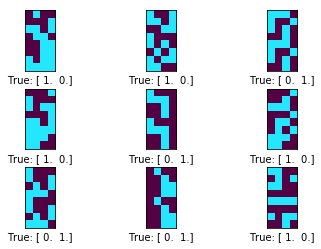

In [7]:
# Get the first images from the train-set.
images = train_data[0:9]
# Get the true classes for those images.
cls_true = train_labels[0:9]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helper Functions for TF Graph Initialization

In [8]:
def new_weights(shape):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape))
#     return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_bias(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper Functions for Network

In [9]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape)
    biases = new_bias(length=num_filters)
    
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)

    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_bias(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

In [ ]:
img_size_flat

In [1]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat*num_channels], name='x')
x_image = tf.reshape(x, [-1, 8, 4, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
x_image.shape, y_true

NameError: name 'tf' is not defined

### Convolution Layers

In [11]:
layer1_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)

layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                           use_pooling=True)

layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                           num_input_channels=num_filters2,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                           use_pooling=True)

layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                           num_input_channels=num_filters3,
                                           filter_size=filter_size4,
                                           num_filters=num_filters4,
                                           use_pooling=True)

In [12]:
layer_flat, num_features = flatten_layer(layer4_conv4)

### Fully Connected Layers

In [13]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)


layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=False)

layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=False)

layer_fc4 = new_fc_layer(input=layer_fc3,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

drop_out = tf.nn.dropout(layer_fc4, 0.5)

##Normalize the numbers(apply softmax!)

y_pred = tf.nn.softmax(drop_out)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [ ]:
layer_fc4

### Cost Function

In [14]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=drop_out,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [15]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## some more performance measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Run Tensorflow on Defined Graph

In [16]:
session = tf.Session()
session.run(tf.global_variables_initializer())

train_batch_size = 64


def optimize(num_iterations):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_batch=0
    end_batch = train_batch_size
    plot_accuracy=[]
    plot_training_size=[]
    
#     for i in range(total_iterations, total_iterations + num_iterations):
    while True:
        train = train_data[start_batch:end_batch]
        labels = train_labels[start_batch:end_batch]
        train, labels = get_batch_images(train, labels)
        if not len(train) and not len(labels):
            print("All images have been processed.")
            break;
            
        x_batch, y_true_batch = next_batch(train_batch_size, train, labels)
#         x_batch, y_true_batch = train_data[done_train_images:done_train_imgs+train_batch_size]
        feed_dict_train = {x: x_batch,
                   y_true: y_true_batch}
        
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if total_iterations%1000==0:    
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(total_iterations + 1, acc))
            plot_accuracy.append(acc)
            plot_training_size.append((total_iterations + 1) * 64)
            
            # Update the total number of iterations performed.
#         done_train_imgs+=train_batch_size
        start_batch += train_batch_size
        end_batch += train_batch_size
        total_iterations +=1
        
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))  
    print(plot_accuracy)
    print(plot_training_size)

### Performance/Optimization

In [17]:
optimize(num_iterations=0)

Optimization Iteration:      1, Training Accuracy:  60.9%
Optimization Iteration:   1001, Training Accuracy:  67.2%
Optimization Iteration:   2001, Training Accuracy:  82.8%
Optimization Iteration:   3001, Training Accuracy:  84.4%
Optimization Iteration:   4001, Training Accuracy:  78.1%
Optimization Iteration:   5001, Training Accuracy:  81.2%
Optimization Iteration:   6001, Training Accuracy:  85.9%
Optimization Iteration:   7001, Training Accuracy:  82.8%
Optimization Iteration:   8001, Training Accuracy:  84.4%
Optimization Iteration:   9001, Training Accuracy:  89.1%
Optimization Iteration:  10001, Training Accuracy:  95.3%
Optimization Iteration:  11001, Training Accuracy:  90.6%
Optimization Iteration:  12001, Training Accuracy:  92.2%
Optimization Iteration:  13001, Training Accuracy:  84.4%
Optimization Iteration:  14001, Training Accuracy:  92.2%
Optimization Iteration:  15001, Training Accuracy:  85.9%
All images have been processed.
Time usage: 0:02:14
[0.609375, 0.671875,

In [20]:
accuracy_sr_plot = [0.5, 0.75, 0.78125, 0.8125, 0.8125, 0.8125, 0.8125, 0.828125, 0.875, 0.90625, 0.78125, 0.90625, 0.78125, 0.921875, 0.828125, 0.921875]
accuracy_sd_plot = [0.421875, 0.484375, 0.484375, 0.453125, 0.578125, 0.515625, 0.5625, 0.5625, 0.5, 0.5625, 0.671875, 0.59375, 0.421875, 0.5625, 0.484375, 0.515625]
accuracy_sd_patchonly_plot = [0.578125, 0.890625, 0.8125, 0.890625, 0.890625, 0.8125, 0.796875, 0.9375, 0.90625, 0.890625, 0.90625, 0.84375, 0.859375, 0.828125, 0.9375, 0.890625]
accuracy_sd_conv_plot = [0.609375, 0.671875, 0.828125, 0.84375, 0.78125, 0.8125, 0.859375, 0.828125, 0.84375, 0.890625, 0.953125, 0.90625, 0.921875, 0.84375, 0.921875, 0.859375]
training_size_sd_plot = [64, 64064, 128064, 192064, 256064, 320064, 384064, 448064, 512064, 576064, 640064, 704064, 768064, 832064, 896064, 960064]

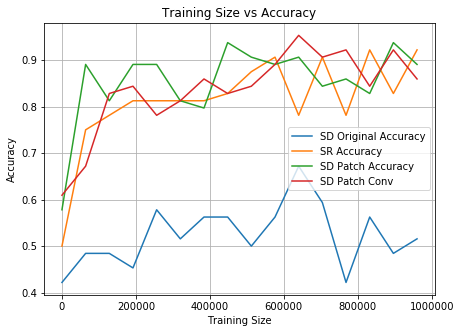

NameError: global name 'path' is not defined

In [21]:
# fig_no, training_size, accuracy, loss, start_size, end_size

generate_size_graph(1, training_size_sd_plot, accuracy_sd_plot, accuracy_sr_plot,accuracy_sd_patchonly_plot,accuracy_sd_conv_plot,  64, 960064)

### Plot Error

In [ ]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Print Accuracy

In [ ]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [ ]:
train_data[:64]

In [ ]:
x_batch, y_true_batch = data.test.next_batch(64)
x_batch

In [ ]:
type(data.train.labels)